In [1]:
import pathlib
import pickle

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import cartopy
import cartopy.crs as ccrs
import cmasher as cmr
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
import galstreams
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import median_absolute_deviation as MAD
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from ezpadova import parsec
from gala.units import galactic
from pyia import GaiaData
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import minimize
from tqdm.auto import tqdm

%matplotlib inline

In [2]:
mwstreams = galstreams.MWStreams()

Initializing galstreams library from master_log... 


## Load data table, compiled in `Stream-data.ipynb`

In [3]:
with open("../data/all_stream_summary_data.pkl", "rb") as f:
    data = pickle.load(f)

In [4]:
for row in data:
    stream = mwstreams.get(row["galstreams_track_name"], None)
    if stream is not None:
        print(row["name"], stream.ref_discovery)
    else:
        print(row["name"])

20.0-1 Mateu2018
300S NiedersteOstholt2009,Simon2011
AAU Koposov2014
Acheron Grillmair2009
Alpheus Grillmair2013
Aquarius Williams2011
C-10
C-11
C-12
C-13
C-19 Ibata2021
C-20
C-22
C-23
C-24
C-25
C-4 Ibata2021
C-5 Ibata2021
C-7 Ibata2021
C-8 Ibata2021
C-9
Cocytos Grillmair2009
Corvus Mateu2018
Elqui Shipp2018
Eridanus Myeong2017
Fimbulthul Ibata2019_OCen,Ibata2019
Fimbulthul-S
Fjorm Palau2019,Ibata2019
GD-1 Grillmair2006_gd1
Gaia-1 Malhan2018
Gaia-10 Ibata2019
Gaia-11 Ibata2021
Gaia-12 Ibata2019
Gaia-2 Malhan2018
Gaia-3 Malhan2018
Gaia-4 Malhan2018
Gaia-5 Malhan2018
Gaia-6 Ibata2019
Gaia-7 Ibata2019
Gaia-8 Ibata2021
Gaia-9 Ibata2021
Gjoll Palau2021,Ibata2019
Gunnthra Ibata2021
Hermus Grillmair2014
Hrid Ibata2021
Hydrus
Hyllus Grillmair2014
Indus Shipp2018
Jet Jethwa2018
Jhelum Shipp2018
Kshir Ibata2021
Kwando Grillmair2017_south
LMS-1 Yuan2020
Leiptr Ibata2019
Lethe Grillmair2009
M2 Grillmair1995
M30 Sollima2020
M5 Grillmair2019
M92 Sollima2020,Thomas2020,Ibata2021
Molonglo Grillmair201

In [6]:
stream.ref_discovery

'Shipp2018'

In [25]:
pre_gaia_colors = cmr.get_sub_cmap(
    "cmr.infinity", 0.0, 0.5, N=len(pre_gaia_ibata) + len(s5_data)
).colors
other_colors = cmr.get_sub_cmap(
    "cmr.infinity", 0.5, 1.0, N=len(all_data) - len(pre_gaia_ibata)
).colors

Text(0, 0.5, 'MSTO $r$ magnitude')

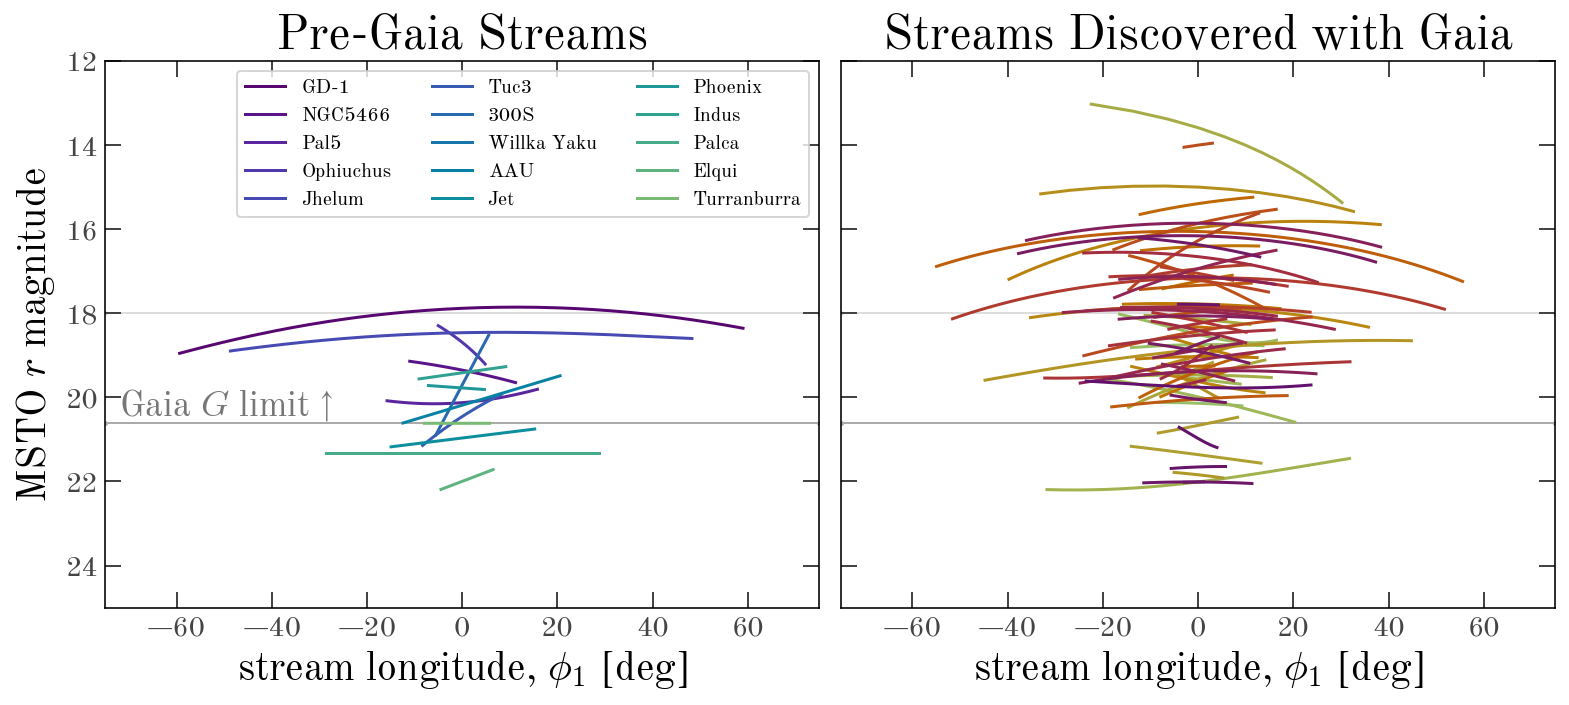

In [26]:
fig, axes = plt.subplots(
    1, 2, figsize=(11, 5), layout="tight", sharex=True, sharey=True
)

pg_i = 0
oth_i = 0
for sid, d in all_data.items():
    if sid in failed:
        continue

    name = sID_to_name[sid]

    phi1_lim = (d["c_fr"].phi1.degree.min(), d["c_fr"].phi1.degree.max())
    orbit_phi1_mask = (d["orbit_fr"].phi1.degree >= phi1_lim[0]) & (
        d["orbit_fr"].phi1.degree <= phi1_lim[1]
    )

    DM = d["orbit_fr"].distance.distmod.value
    HB_r = DM + HB_absmag
    MSTO_r = DM + MSTO_absmag

    # print(sid, DM[orbit_phi1_mask], MSTO_r[orbit_phi1_mask])

    if name in pre_gaia_ibata:
        ax = axes[0]
        c = pre_gaia_colors[pg_i]
        pg_i += 1
    else:
        ax = axes[1]
        c = other_colors[oth_i]
        oth_i += 1
    ax.plot(
        d["orbit_fr"].phi1.degree[orbit_phi1_mask],
        MSTO_r[orbit_phi1_mask],
        marker="",
        label=f"{name}",
        color=c,
    )

for pg_i, row in enumerate(s5_data, start=pg_i):
    c = pre_gaia_colors[pg_i]
    ax.plot(
        row["phi1"],
        row["distmod"] + MSTO_absmag,
        marker="",
        label=f"{row['name']}",
        color=c,
    )

axes[0].legend(ncols=3)

ax.set_xlim(-75, 75)
ax.set_ylim(25, 12)

for ax in axes:
    ax.set_xlabel(r"stream longitude, $\phi_1$ [deg]")
    # ax.axhspan(20.6, max(ax.get_ylim()), linewidth=0, zorder=-100, color='#dddddd')
    ax.axhline(20.6, linewidth=1, zorder=-100, color="#aaaaaa")
    ax.axhline(18, linewidth=1, zorder=-100, color="#dddddd")

axes[0].text(
    ax.get_xlim()[0] + 3,
    20.6,
    "Gaia $G$ limit ↑",
    ha="left",
    va="bottom",
    fontsize=18,
    color="#777777",
)

axes[0].set_title("Pre-Gaia Streams")
axes[1].set_title("Streams Discovered with Gaia")
axes[0].set_ylabel("MSTO $r$ magnitude")

# fig.savefig("../tex/figures/msto-rc-mag.pdf")

Estimate a more realistic spectroscopic limit, based on:
https://www.lco.cl/technical-documentation/the-mike-magellan-inamori-kyocera-echelle-users-guide/

In [27]:
V = 17.0
SNR = 50
R = 30_000
ref_lambda = 5500 * u.angstrom

req = SNR**2 * u.electron / u.pixel
num1 = (
    1.0
    * u.electron
    / u.second
    / u.Angstrom
    * ref_lambda
    / R
    / u.pixel
    * 10 ** (0.4 * (18.4 - V))
    * 0.7
)
(req / num1).to(u.hour)

<Quantity 1.4903835 h>

/var/folders/rt/whnwmp_97v9g6dldf5lr38l80000gr/T/ipykernel_41842/3783385705.py:35: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(
/var/folders/rt/whnwmp_97v9g6dldf5lr38l80000gr/T/ipykernel_41842/3783385705.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


Text(0, 0.5, 'MSTO $r$ magnitude')

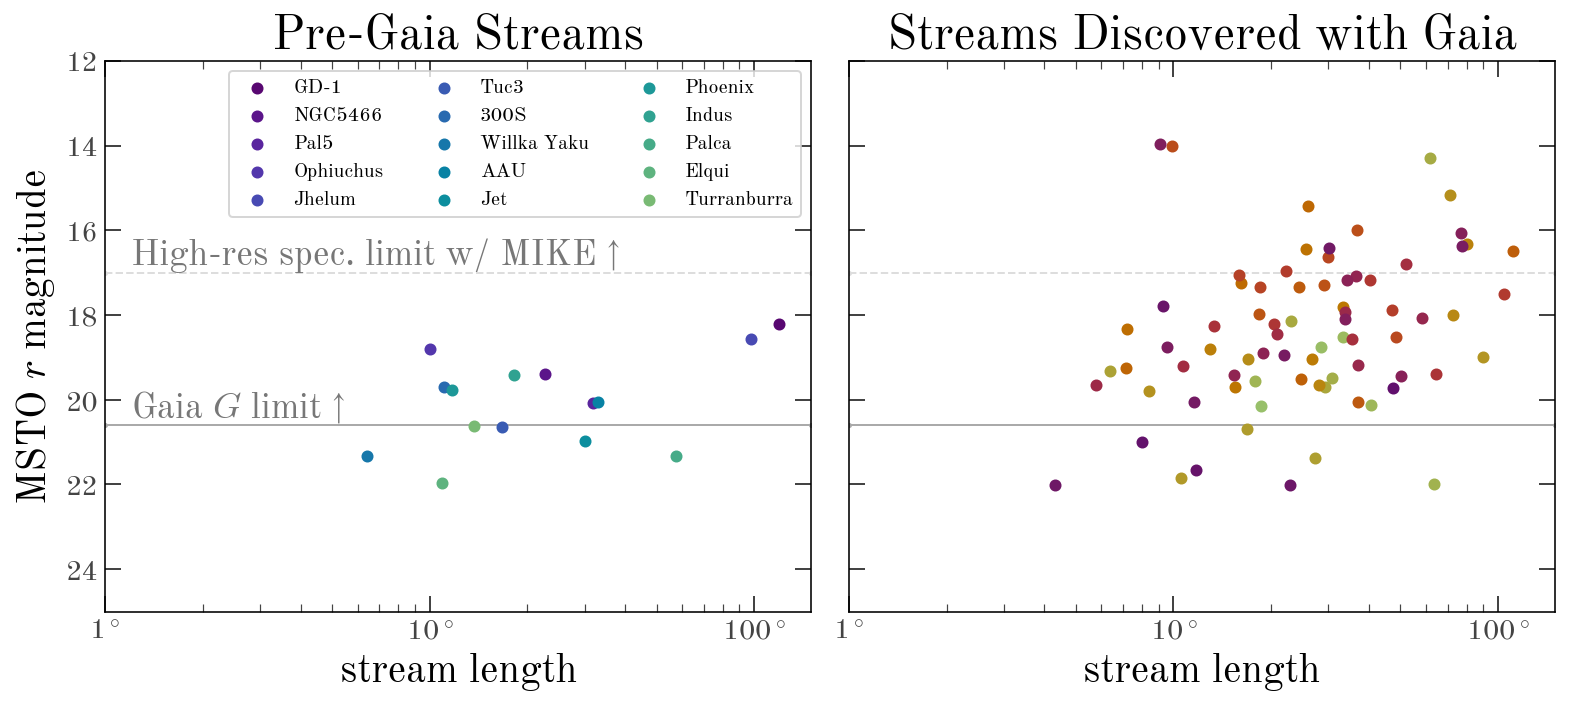

In [28]:
fig, axes = plt.subplots(
    1, 2, figsize=(11, 5), layout="tight", sharex=True, sharey=True
)

pg_i = 0
oth_i = 0
for sid, d in all_data.items():
    if sid in failed:
        continue

    name = sID_to_name[sid]

    phi1_lim = (d["c_fr"].phi1.degree.min(), d["c_fr"].phi1.degree.max())
    size = phi1_lim[1] - phi1_lim[0]
    orbit_phi1_mask = (d["orbit_fr"].phi1.degree >= phi1_lim[0]) & (
        d["orbit_fr"].phi1.degree <= phi1_lim[1]
    )
    DM = np.mean(d["orbit_fr"].distance.distmod.value[orbit_phi1_mask])
    MSTO_r = DM + MSTO_absmag
    # if size < 10:
    #     print(name, DM, MSTO_r)
    #     ax.text(size, MSTO_r, name)
    # else:
    #     continue

    if name in pre_gaia_ibata:
        ax = axes[0]
        c = pre_gaia_colors[pg_i]
        pg_i += 1
    else:
        ax = axes[1]
        c = other_colors[oth_i]
        oth_i += 1

    ax.scatter(
        size,
        MSTO_r,
        marker="o",
        label=f"{name}",
        c=c,
    )

for pg_i, row in enumerate(s5_data, start=pg_i):
    c = pre_gaia_colors[pg_i]
    ax.scatter(
        row["phi1"].max() - row["phi1"].min(),
        np.mean(row["distmod"]) + MSTO_absmag,
        marker="o",
        label=f"{row['name']}",
        c=c,
    )

axes[0].legend(ncols=3)

ax.set(
    xscale="log",
    xlim=(1, 150),
    ylim=(25, 12),
    xticks=[1, 10, 100],
    xticklabels=[r"1$^\circ$", r"10$^\circ$", r"100$^\circ$"],
)

for ax in axes:
    ax.set_xlabel(r"stream length")
    # ax.axhspan(20.6, max(ax.get_ylim()), linewidth=0, zorder=-100, color='#dddddd')
    ax.axhline(20.6, linewidth=1, zorder=-100, color="#aaaaaa")
    ax.axhline(V, linewidth=1, zorder=-100, color="#dddddd", linestyle="--")

axes[0].text(
    ax.get_xlim()[0] + 0.2,
    20.6,
    "Gaia $G$ limit ↑",
    ha="left",
    va="bottom",
    fontsize=18,
    color="#777777",
)

axes[0].text(
    ax.get_xlim()[0] + 0.2,
    V,
    "High-res spec. limit w/ MIKE ↑",
    ha="left",
    va="bottom",
    fontsize=18,
    color="#777777",
)

axes[0].set_title("Pre-Gaia Streams")
axes[1].set_title("Streams Discovered with Gaia")
axes[0].set_ylabel("MSTO $r$ magnitude")

# fig.savefig("../tex/figures/msto-rc-mag.pdf")

In [109]:
pre = {"name": [], "size": [], "r": [], "mass": []}
post = {"name": [], "size": [], "r": [], "mass": []}
for sid, d in all_data.items():
    if sid in failed:
        continue

    name = sID_to_name[sid]

    phi1_lim = (d["c_fr"].phi1.degree.min(), d["c_fr"].phi1.degree.max())
    size = phi1_lim[1] - phi1_lim[0]
    orbit_phi1_mask = (d["orbit_fr"].phi1.degree >= phi1_lim[0]) & (
        d["orbit_fr"].phi1.degree <= phi1_lim[1]
    )
    DM = np.mean(d["orbit_fr"].distance.distmod.value[orbit_phi1_mask])
    MSTO_r = DM + MSTO_absmag

    # Estimate initial stellar mass:
    idx = np.where((iso["G"] + DM) < 20.0)[0]
    dIMF = iso["int_IMF"][idx[-1]] - iso["int_IMF"][idx[0]]
    M = 2.0 * len(d["c_fr"]) / dIMF

    if name in pre_gaia_ibata:
        pre["name"].append(name)
        pre["size"].append(size)
        pre["r"].append(MSTO_r)
        pre["mass"].append(M)
    else:
        post["name"].append(name)
        post["size"].append(size)
        post["r"].append(MSTO_r)
        post["mass"].append(M)

for row in s5_data:
    pre["name"].append(row["name"])
    pre["size"].append(row["phi1"].max() - row["phi1"].min())
    pre["r"].append(np.mean(row["distmod"]) + MSTO_absmag)
    pre["mass"].append(row["mass"])

pre = at.Table(pre)
post = at.Table(post)

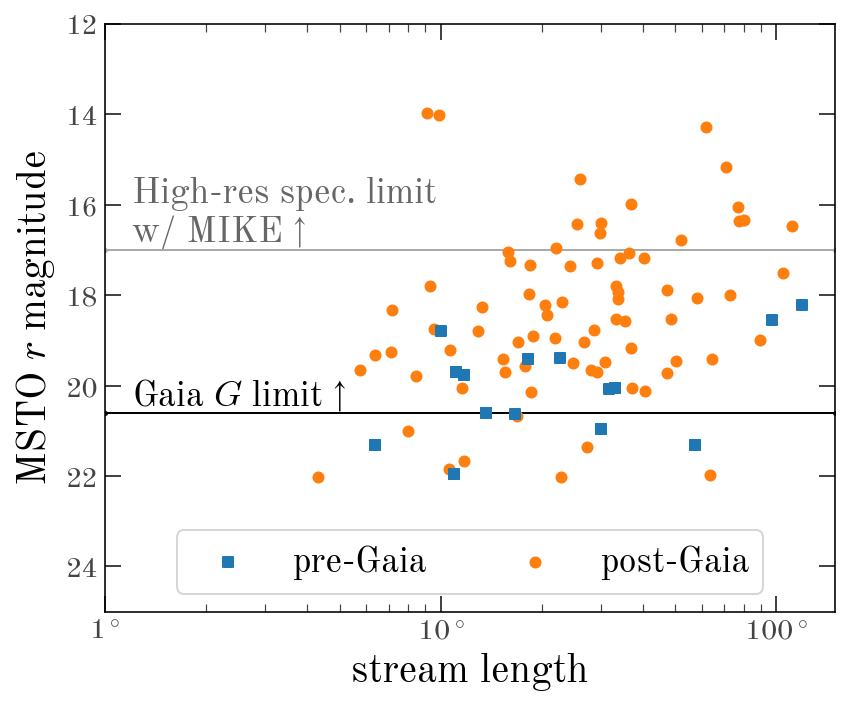

In [110]:
pre_gaia_color = "tab:blue"
pre_gaia_marker = "s"
post_gaia_color = "tab:orange"
post_gaia_marker = "o"


fig, ax = plt.subplots(1, 1, figsize=(6, 5), layout="tight")

ax.scatter(
    pre["size"],
    pre["r"],
    label="pre-Gaia",
    c=pre_gaia_color,
    marker=pre_gaia_marker,
    zorder=100,
)
ax.scatter(
    post["size"],
    post["r"],
    label="post-Gaia",
    c=post_gaia_color,
    marker=post_gaia_marker,
    zorder=10,
)
ax.legend(loc="lower center", ncols=2, fontsize=18)

for row in s5_data:
    ax.scatter(
        row["phi1"].max() - row["phi1"].min(),
        np.mean(row["distmod"]) + MSTO_absmag,
        marker=pre_gaia_marker,
        label=f"{row['name']}",
        c=pre_gaia_color,
        zorder=100,
    )

ax.set(
    xscale="log",
    xlim=(1, 150),
    ylim=(25, 12),
    xticks=[1, 10, 100],
    xticklabels=[r"1$^\circ$", r"10$^\circ$", r"100$^\circ$"],
)


# ax.axhspan(20.6, max(ax.get_ylim()), linewidth=0, zorder=-100, color='#dddddd')
ax.axhline(20.6, linewidth=1, zorder=-100, color="k")
ax.axhline(V, linewidth=1, zorder=-100, color="#aaaaaa", linestyle="-")

ax.text(
    ax.get_xlim()[0] + 0.2,
    20.6,
    "Gaia $G$ limit ↑",
    ha="left",
    va="bottom",
    fontsize=18,
    color="k",
)

ax.text(
    ax.get_xlim()[0] + 0.2,
    V,
    "High-res spec. limit \nw/ MIKE ↑",
    ha="left",
    va="bottom",
    fontsize=18,
    color="#666666",
)

# ax.set_title("Pre-Gaia Streams")
# ax.set_title("Streams Discovered with Gaia")
ax.set_xlabel(r"stream length")
ax.set_ylabel("MSTO $r$ magnitude")

fig.savefig("../tex/figures/msto-rc-mag.pdf")

Text(0, 0.5, 'rough total stellar mass')

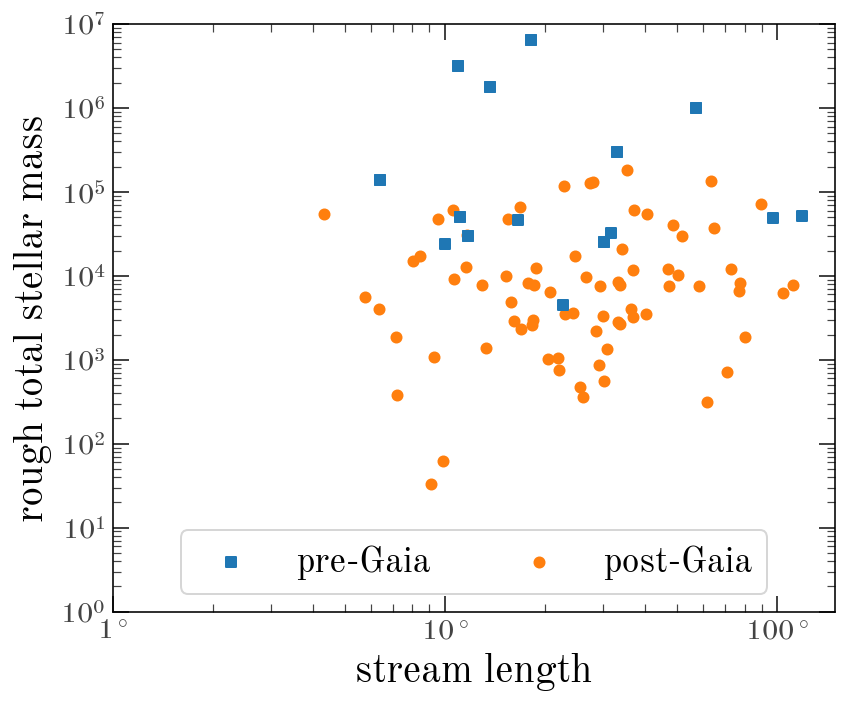

In [111]:
pre_gaia_color = "tab:blue"
pre_gaia_marker = "s"
post_gaia_color = "tab:orange"
post_gaia_marker = "o"


fig, ax = plt.subplots(1, 1, figsize=(6, 5), layout="tight")

ax.scatter(
    pre["size"],
    pre["mass"],
    label="pre-Gaia",
    c=pre_gaia_color,
    marker=pre_gaia_marker,
    zorder=100,
)
# for row in pre:
#     if not np.isfinite(row["mass"]):
#         continue
#     ax.text(row["size"], row["mass"], row["name"])

ax.scatter(
    post["size"],
    post["mass"],
    label="post-Gaia",
    c=post_gaia_color,
    marker=post_gaia_marker,
    zorder=10,
)
ax.legend(loc="lower center", ncols=2, fontsize=18)

for row in s5_data:
    ax.scatter(
        row["phi1"].max() - row["phi1"].min(),
        # np.mean(row["distmod"]) + MSTO_absmag,
        row["mass"],
        marker=pre_gaia_marker,
        label=f"{row['name']}",
        c=pre_gaia_color,
        zorder=100,
    )

ax.set(
    xscale="log",
    yscale="log",
    xlim=(1, 150),
    ylim=(1, 1e7),
    xticks=[1, 10, 100],
    xticklabels=[r"1$^\circ$", r"10$^\circ$", r"100$^\circ$"],
)

# ax.set_title("Pre-Gaia Streams")
# ax.set_title("Streams Discovered with Gaia")
ax.set_xlabel(r"stream length")
ax.set_ylabel("rough total stellar mass")

---

## Sky plot

Plot the sky tracks of all streams - Ibata and S5 streams get color, other galstreams streams gray.

## Prepare stream tracks:

TODO: alpha set by number of stars or stellar mass? or color instead? or surface brightness?

In [112]:
# def get_full_galstreams_poly(poly_sc):
#     split_i = np.where(np.abs(np.diff(poly_sc.phi2.degree)) > 0.5)[0][0] + 1

#     nodes = np.concatenate(
#         (
#             np.stack((poly_sc.phi1.degree[:split_i], poly_sc.phi2.degree[:split_i])).T,
#             np.stack(
#                 (
#                     np.full(128, poly_sc.phi1.degree[split_i]),
#                     np.linspace(
#                         poly_sc.phi2.degree[split_i - 1],
#                         poly_sc.phi2.degree[split_i],
#                         128,
#                     ),
#                 )
#             ).T,
#             np.stack(
#                 (
#                     poly_sc.phi1.degree[split_i + 1 : -1],
#                     poly_sc.phi2.degree[split_i + 1 : -1],
#                 )
#             ).T,
#             np.stack(
#                 (
#                     np.full(128, poly_sc.phi1.degree[0]),
#                     np.linspace(
#                         poly_sc.phi2.degree[-2],
#                         poly_sc.phi2.degree[0],
#                         128,
#                     ),
#                 )
#             ).T,
#         )
#     )

#     # reverse order below to make the points wind counter-clockwise = convex
#     poly_sc = coord.SkyCoord(
#         phi1=nodes[::-1, 0] * u.deg,
#         phi2=nodes[::-1, 1] * u.deg,
#         frame=poly_sc.frame.replicate_without_data(),
#     )
#     return poly_sc

In [70]:
ibata_names = [sID_to_name[sid] for sid in all_data.keys()]

track_nodes = {}
for sid, d in all_data.items():
    if sid == 48:
        continue  # skip Orphan

    poly = np.polynomial.Polynomial.fit(
        d["c_fr"].phi1.degree, d["c_fr"].phi2.degree, deg=2
    )
    xgrid = np.linspace(d["c_fr"].phi1.degree.min(), d["c_fr"].phi1.degree.max(), 128)
    mu = poly(xgrid)
    sigma = MAD(d["c_fr"].phi2.degree - poly(d["c_fr"].phi1.degree))

    nodes = np.concatenate(
        (
            np.stack((xgrid, mu - 3 * sigma)).T,
            np.stack(
                (
                    np.full(128, xgrid[-1]),
                    np.linspace(mu[-1] - 3 * sigma, mu[-1] + 3 * sigma, 128),
                )
            ).T,
            np.stack((xgrid, mu + 3 * sigma)).T[::-1],
            np.stack(
                (
                    np.full(128, xgrid[0]),
                    np.linspace(mu[0] - 3 * sigma, mu[0] + 3 * sigma, 128),
                )
            ).T[::-1],
        )
    )
    track_nodes[sid] = coord.SkyCoord(
        phi1=nodes[:, 0] * u.deg,
        phi2=nodes[:, 1] * u.deg,
        frame=d["c_fr"].frame.replicate_without_data(),
    )

    # plt.figure()
    # plt.scatter(d["c_fr"].phi1.degree, d["c_fr"].phi2.degree)
    # plt.fill_between(
    #     xgrid, mu - 3 * sigma, mu + 3 * sigma, color="tab:blue", zorder=-10, alpha=0.5
    # )
    # plt.plot(nodes[:, 0], nodes[:, 1])

# Now add other galstreams tracks for confirmed streams:
tmp = {
    "300S": None,
    "Elqui": None,
    "Jet": "Jet-F22",
    "Orphan": "Orphan-K19",
    "Palca": None,
    "Willka Yaku": None,
    "Turranburra": None,
}
for name, track_name in tmp.items():
    if " " in name:
        name = name.replace(" ", "_")

    if track_name is None:
        track_name = mwstreams.get_track_names_for_stream(name)[0]

    poly_sc = get_full_galstreams_poly(mwstreams[track_name].poly_sc)

    try:
        track_nodes[name_to_sID[name]] = poly_sc
    except KeyError:
        track_nodes[name] = poly_sc

In [72]:
# Now add all other galstreams tracks:
other_track_nodes = {}
for track_name, track in mwstreams.items():
    # These are either not halo streams, or already in the Ibata catalog
    if (
        track.stream_name
        in [
            "Sagittarius",
            "ACS",
            "Monoceros",
            "Cetus-New",
            "Cetus-Palca",
            "OmegaCen-Fimbulthul",
            "M68-Fjorm",
            "Jhelum-a",
            "Jhelum-b",
            "NGC3201-Gjoll",
            "AAU-AliqaUma",
            "AAU-ATLAS",
            "TucIII",
        ]
        or track.stream_name in ibata_names
        or track.stream_name in track_nodes.keys()
    ):
        continue

    poly_sc = get_full_galstreams_poly(mwstreams[track_name].poly_sc)

    try:
        other_track_nodes[name_to_sID[track.stream_name]] = poly_sc
    except KeyError:
        other_track_nodes[track.stream_name] = poly_sc

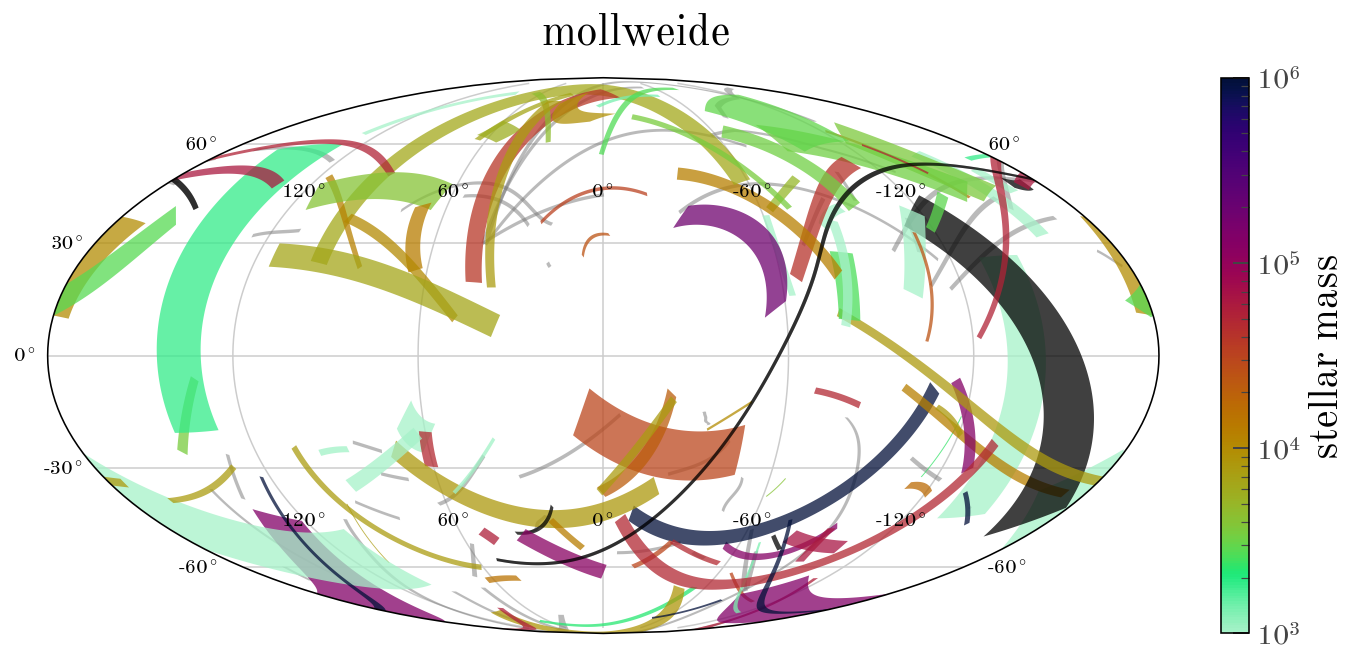

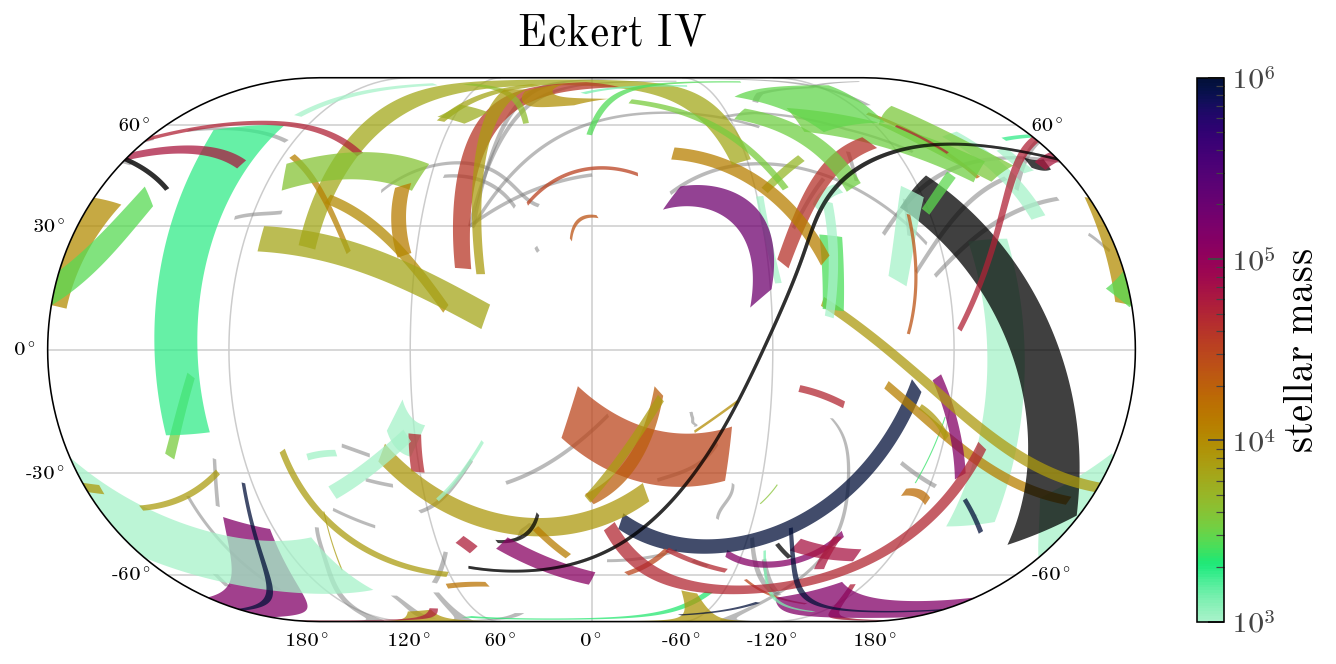

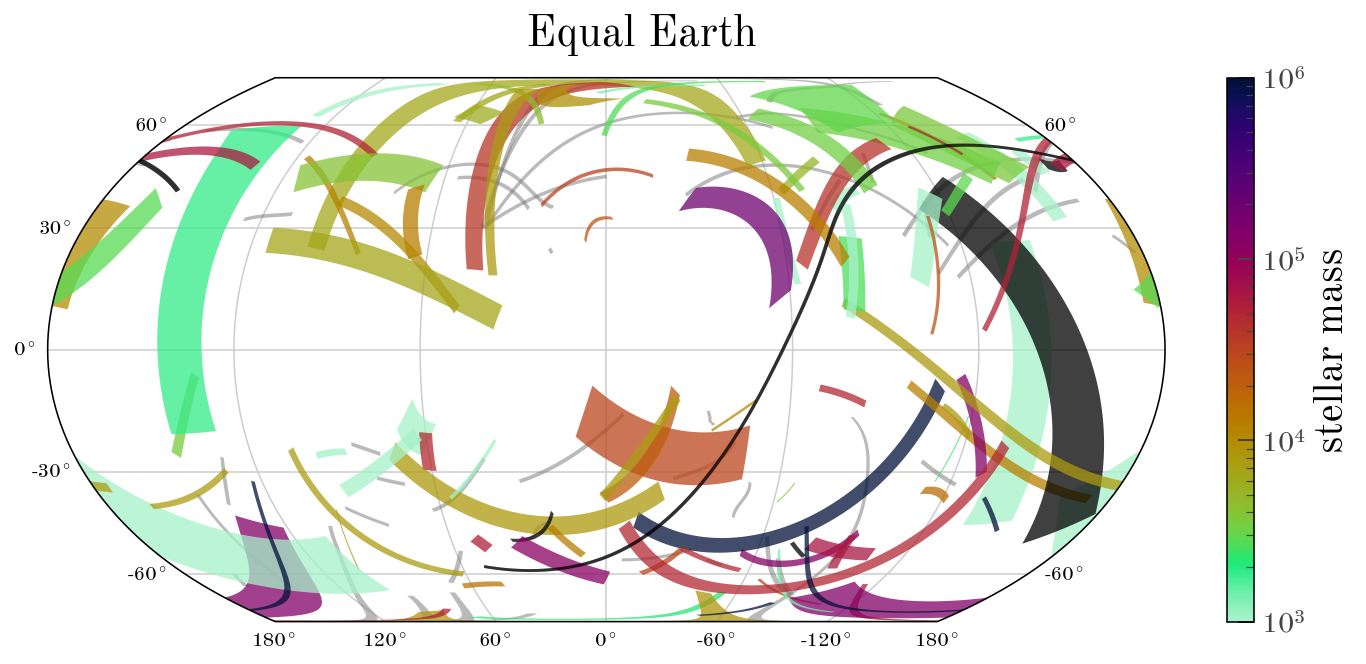

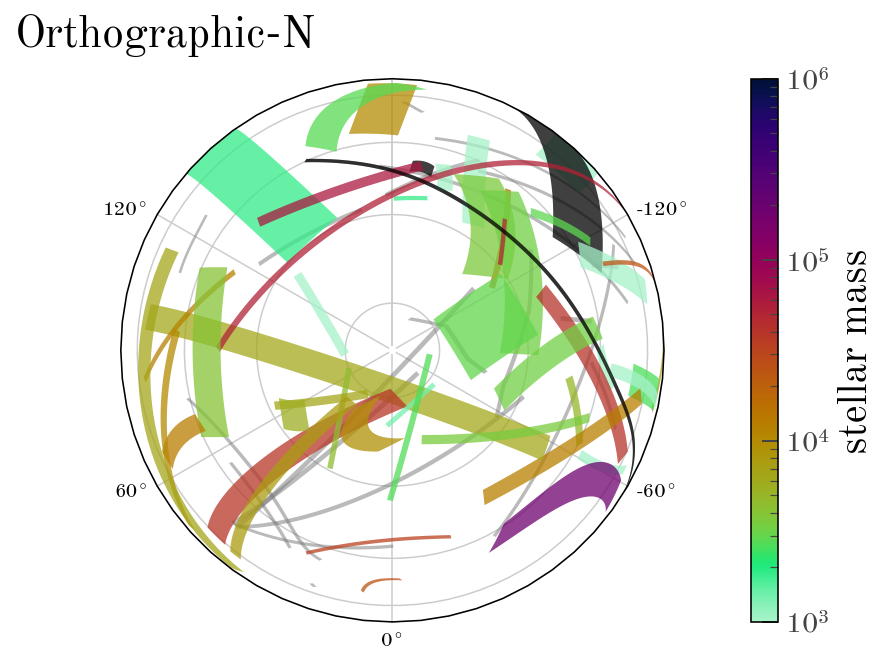

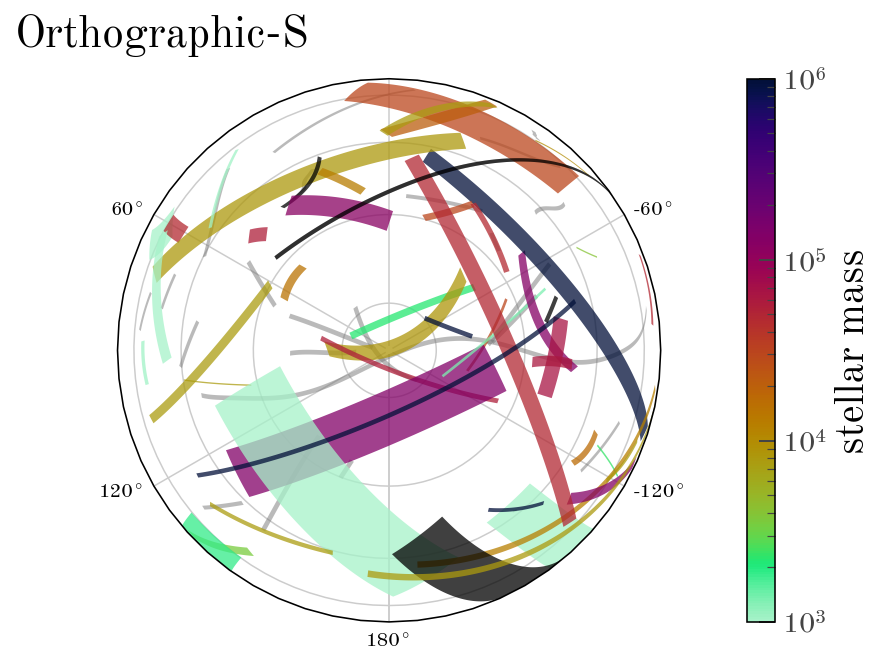

In [139]:
# proj = ccrs.EqualEarth()
projs = {
    "mollweide": ccrs.Mollweide(),
    "Eckert IV": ccrs.EckertIV(),
    "Equal Earth": ccrs.EqualEarth(),
    "Orthographic-N": ccrs.Orthographic(central_latitude=90.0),
    "Orthographic-S": ccrs.Orthographic(central_latitude=-90.0),
}

for proj_name, proj in projs.items():
    fig, ax = plt.subplots(
        figsize=(10, 4.5), subplot_kw=dict(projection=proj), layout="constrained"
    )
    ax.set_global()

    norm = mpl.colors.LogNorm(1e3, 1e6)
    cmap = cmr.get_sub_cmap(plt.get_cmap("cmr.chroma_r"), start=0.1, stop=0.9)

    for sid, track in track_nodes.items():
        if sid in sID_to_name:
            name = sID_to_name[sid]
        else:
            name = sid

        if name in pre["name"]:
            mass = pre[pre["name"] == name]["mass"][0]
        elif name in post["name"]:
            mass = post[post["name"] == name]["mass"][0]
        else:
            mass = np.nan

        color = cmap(norm(mass))

        poly = mpl.patches.Polygon(
            np.stack(
                # (track.galactic.l.wrap_at(180 * u.deg).radian, track.galactic.b.radian)
                (track.galactic.l.wrap_at(180 * u.deg).degree, track.galactic.b.degree)
            ).T,
            color=color,
            alpha=0.75,
            transform=ccrs.Geodetic(),
            linewidth=0,
        )
        ax.add_patch(poly)

        # ax.text(*poly.get_xy()[0], name, color=color, fontsize=10, transform=ccrs.Geodetic())

        # d = all_data[sid]
        # (l,) = ax.plot(
        #     track.galactic.l.wrap_at(180 * u.deg).degree,
        #     track.galactic.b.degree,
        #     color="tab:blue",
        #     alpha=0.5,
        #     zorder=-10,
        #     marker="",
        #     lw=1,
        #     transform=ccrs.Geodetic()
        # )
        # ax.scatter(d["c_fr"].galactic.l.wrap_at(180 * u.deg).degree, d["c_fr"].galactic.b.degree, c=l.get_color(), transform=ccrs.Geodetic())

    for track in other_track_nodes.values():
        poly = mpl.patches.Polygon(
            np.stack(
                # (track.galactic.l.wrap_at(180 * u.deg).radian, track.galactic.b.radian)
                (track.galactic.l.wrap_at(180 * u.deg).degree, track.galactic.b.degree)
            ).T,
            color="#777777",
            linewidth=0,
            alpha=0.5,
            transform=ccrs.Geodetic(),
            zorder=-10,
        )
        ax.add_patch(poly)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cb = fig.colorbar(sm, ax=ax)
    cb.set_label("stellar mass")

    lon_formatter = LongitudeFormatter(zero_direction_label=True, direction_label=False)
    lat_formatter = LatitudeFormatter(direction_label=False)
    gl = ax.gridlines(
        draw_labels=True,
        xformatter=lon_formatter,
        yformatter=lat_formatter,
        color="#cccccc",
        zorder=-25,
    )
    gl.top_labels = False
    gl.right_labels = False

    ax.invert_xaxis()
    fig.suptitle(proj_name, fontsize=22)

TODO: there are more classes:
- pre-gaia discovered, gaia confirmed
- pre-gaia discovered, unconfirmed
- post-gaia discovered, confirmed
- post-gaia discovered, unconfirmed

In [117]:
for name in post[post["mass"] > 8e4]["name"]:
    d = all_data[name_to_sID[name]]
    break

(-90.0, 90.0)

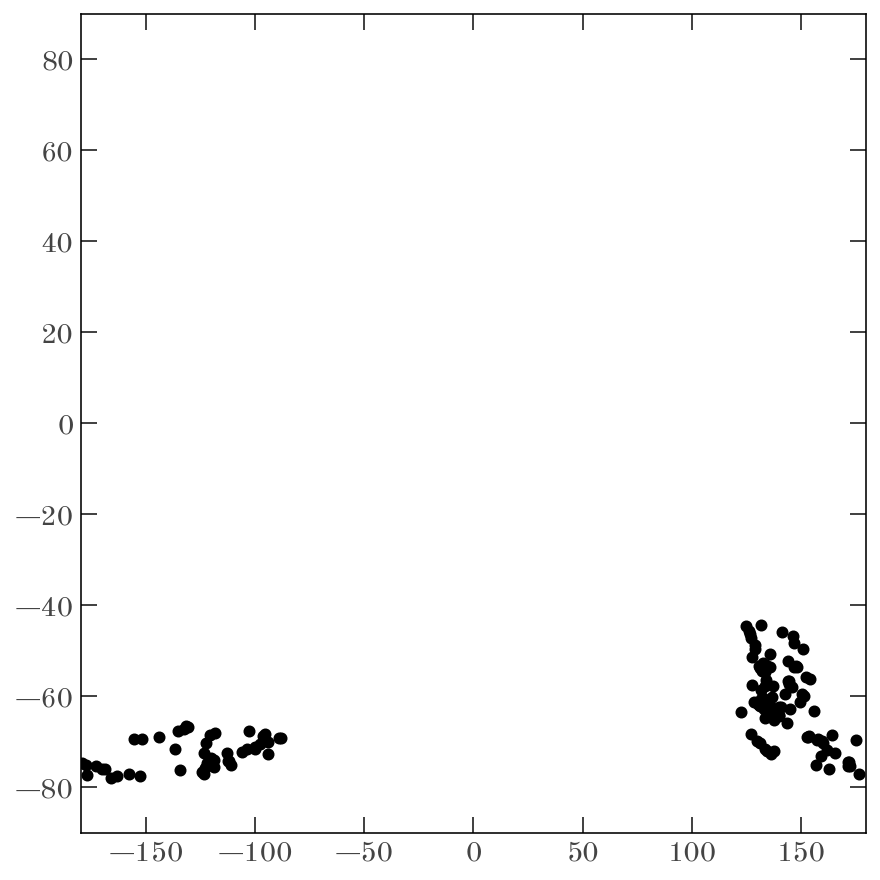

In [125]:
plt.scatter(
    d["c_fr"].galactic.l.wrap_at(180 * u.deg).degree, d["c_fr"].galactic.b.degree
)
plt.xlim(-180, 180)
plt.ylim(-90, 90)

In [115]:
post[post["mass"] > 8e4]

name,size,r,mass
str12,float64,float64,float64
Kwando,63.61565298799118,21.989015637750224,134202.08110473832
NGC1261,27.326183415098136,21.369562287750682,126204.59734897809
C-12,28.0143524416658,19.648564218533988,130898.07492470474
Fimbulthul,35.464912546497494,18.56706462358757,182117.56167863085
New-26,22.83032908322774,22.022804600860265,117669.94067879229


TODO: background for stream sky plot?

```
SELECT subquery.healpix_9, COUNT(*) AS N, SUM(phot_g_mean_flux) AS sum_g, SUM(phot_bp_mean_flux) AS sum_bp, SUM(phot_rp_mean_flux) AS sum_rp
FROM (
  SELECT GAIA_HEALPIX_INDEX(9, source_id) AS healpix_9, phot_g_mean_flux, phot_bp_mean_flux, phot_rp_mean_flux
  FROM gaiadr3.gaia_source
) AS subquery
GROUP BY subquery.healpix_9
```

In [ ]:
order = 6
hpx = at.Table.read("/Users/apricewhelan/Downloads/1706913356825O-result.fits.gz")
assert hp.order2npix(order) == len(hpx)

/Users/apricewhelan/anaconda3/lib/python3.10/site-packages/healpy/visufunc.py:332: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  pylab.draw()
/Users/apricewhelan/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


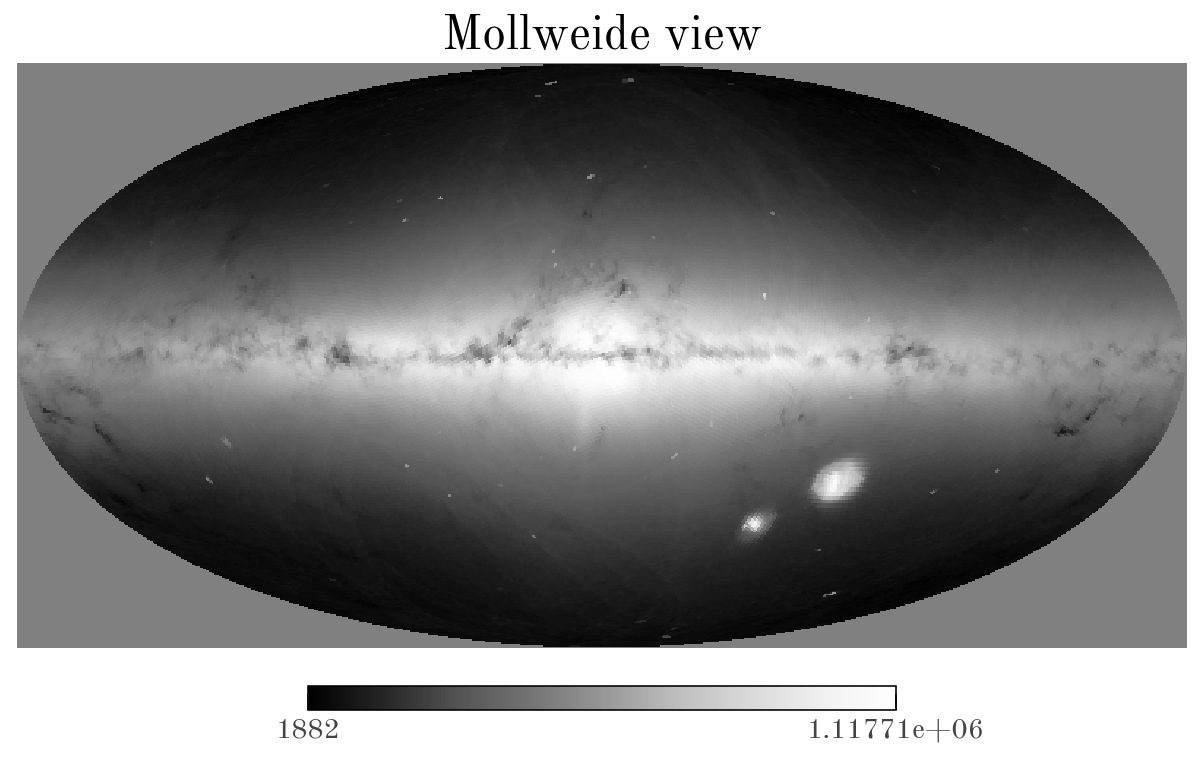

In [ ]:
hpx_map = np.full(hp.order2npix(order), np.nan)
hpx_map[hpx["healpix_6"]] = hpx["N"]
# hpx_map[hpx['healpix_6']] = np.log(hpx['sum_bp'] / hpx['sum_rp'])
hp.mollview(
    hpx_map,
    nest=True,
    cmap="Greys_r",
    rot=[266.40498829, -28.93617776, 59.0],
    norm=mpl.colors.LogNorm(),
)

/var/folders/rt/whnwmp_97v9g6dldf5lr38l80000gr/T/ipykernel_45243/2382963341.py:531: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=left, right=right, top=top, bottom=bottom)


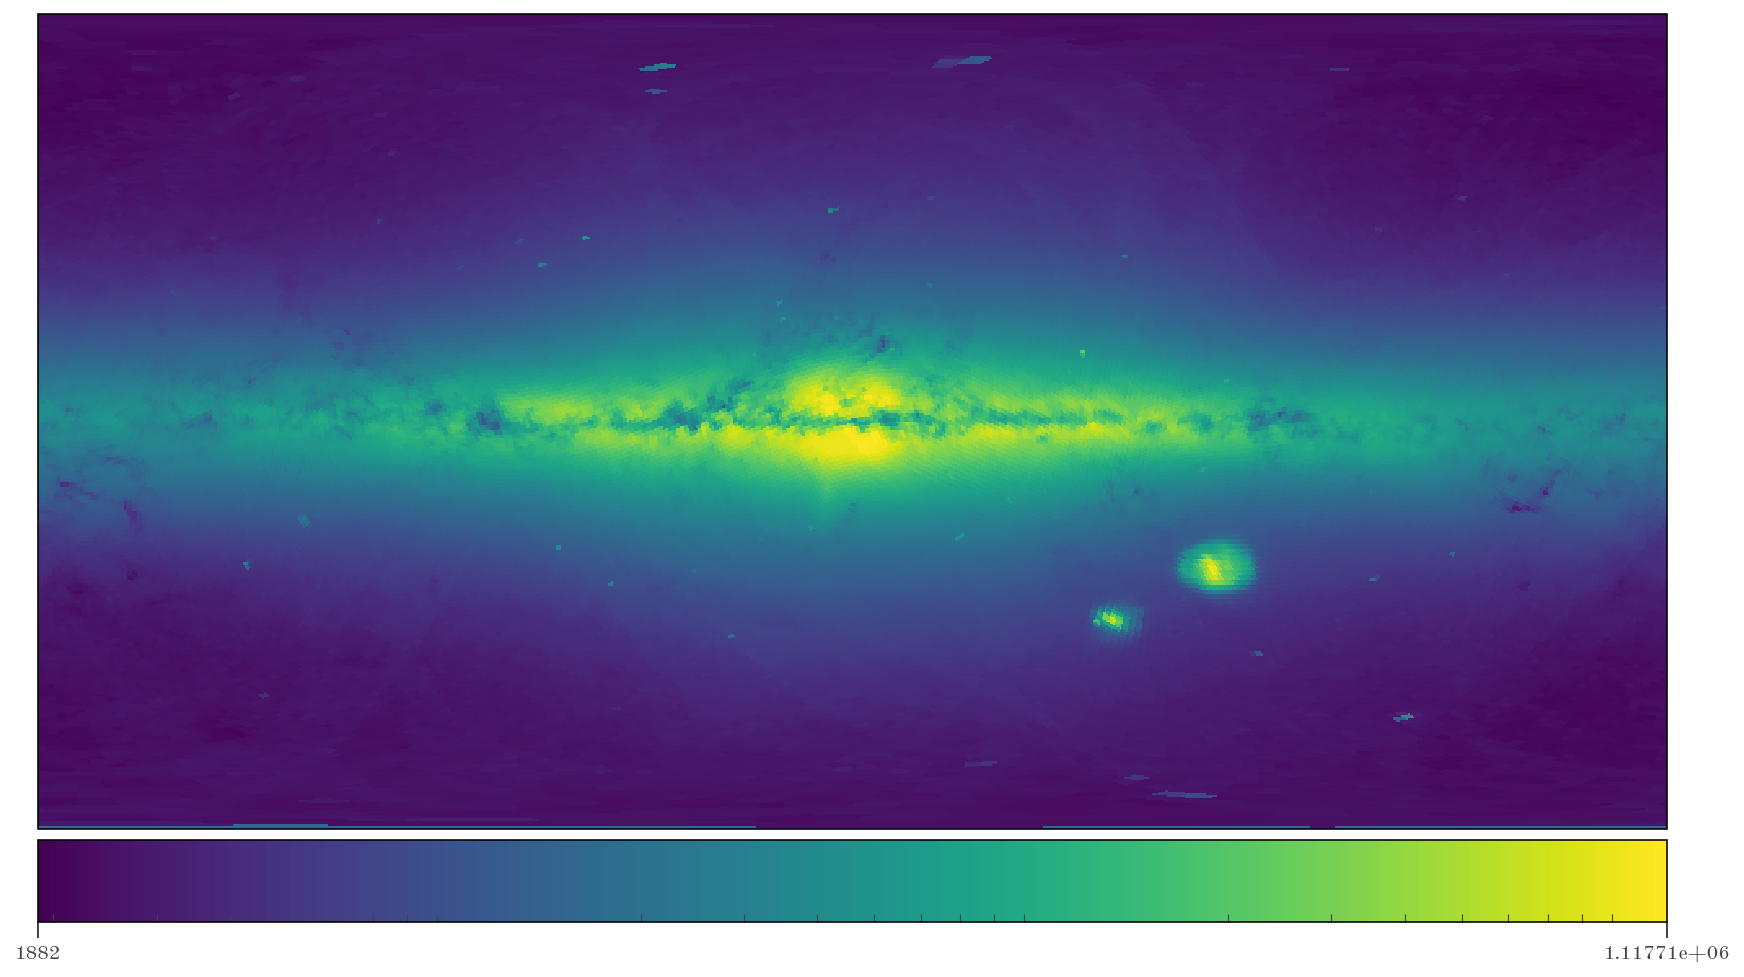

In [ ]:
import cartopy.crs as ccrs

# hp.newvisufunc.projview(hpx_map, projection_type=ccrs.EckertIV());
projview(
    hpx_map,
    projection_type=ccrs.EqualEarth(),
    nest=True,
    rot=[266.40498829, -28.93617776, 59.0],
    norm=mpl.colors.LogNorm(),
    xsize=1000,
)